# Домашнее задание №6. 
Обучить сиамскую сеть для верификации лиц на датасете LFW

In [106]:
#импорт библиотек
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

### Создание и подготовка данных

In [107]:
# Загрузка датасета 
(ds_train, ds_test), ds_info = tfds.load('lfw', split=['train[:75%]', 'train[75%:]'], shuffle_files=True, as_supervised=True, with_info=True)

In [108]:
len(ds_train), len(ds_test)

(9925, 3308)

In [109]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

In [110]:
ds_train.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

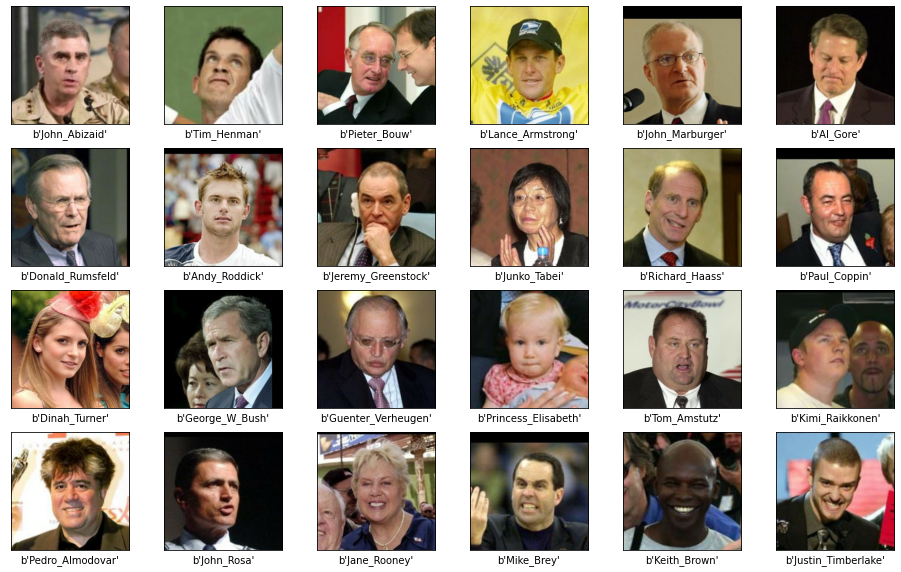

In [111]:
fig = plt.figure(figsize=(16, 10))
j = 0

for label, image in tfds.as_numpy(ds_train.take(24)):
  ax = fig.add_subplot(4, 6, j+1)
  ax.imshow(image)
  plt.xticks([]), plt.yticks([])
  plt.xlabel(str(label))
  j += 1
plt.show()

### Подготовка пайплайна данных

In [112]:
INP_SIZE = 250
NUM_EPOCHS = 5
BATCH_SIZE = 64

#предварительная обработка данных
def preprocessing(img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE))

#создание датасетов
train_ds = ds_train.shuffle(buffer_size=len(ds_train))
train_ds = train_ds.map(lambda label, img: (preprocessing(img), label))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = ds_test.shuffle(buffer_size=len(ds_test))
test_ds = test_ds.map(lambda label, img: (preprocessing(img), label))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

### Создание Сверточной нейронной сети

In [140]:
EMB_SIZE = 256

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # в последнем слое получаем Embedding (количество нейронов = длина эмбеддинга)
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

model.build(input_shape = (None, INP_SIZE, INP_SIZE, 3))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 250, 250, 32)      2432      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      51264     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 246016)            0         
                                                                 
 dense_24 (Dense)            (None, 512)             

In [141]:
# Loss функция

MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]

    # разбиваем батч эмбедингов и меток на 2 равные части
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [142]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [143]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 77.21612548828125
[200] Loss: 0.04725690558552742
[400] Loss: 0.12915270030498505
[600] Loss: 0.23707695305347443
CPU times: user 3min 22s, sys: 6.87 s, total: 3min 29s
Wall time: 3min 39s


### Тестирование модели

#### 1 СЛУЧАЙ

In [144]:
# 1 СЛУЧАЙ
# Объект из тестового датасета есть в тренировочном

person_1 = b'Arnold_Schwarzenegger'
person_2 = b'Tom_Hanks'

In [145]:
#выберем изображения из тестового датасета: 2 для person_1 и 1 для person_2
test_img_list_A = [image for label, image in ds_test if label.numpy() == person_1] [:2] # первые 2 элемента
test_img_list_B = [image for label, image in ds_test if label.numpy() == person_2][:1] # первый элемент

img_a1 = preprocessing(test_img_list_A[0])
img_a2 = preprocessing(test_img_list_A[1])
img_b1 = preprocessing(test_img_list_B[0])

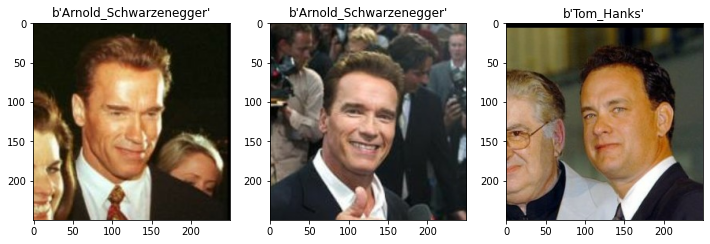

In [146]:
# визуализация выбранных данных из тестового датасета
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.title(person_2)
plt.show()

In [147]:
#получение эмбеддингов для новых данных
#(из трех тензоров (250, 250, 3) делаем один (3, 250, 250, 3) (стыкуем по вертикали) и помещаем в модель)

new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0)) 

In [148]:
#функция вычисления расстояния между векторами (эмбеддингами)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print(f'{person_1}_1 <-> {person_1}_2: ', diff(emb1, emb2))
print(f'{person_1}_1 <-> {person_2}_1: ', diff(emb1, emb3))
print(f'{person_1}_2 <-> {person_2}_1: ', diff(emb2, emb3))

b'Arnold_Schwarzenegger'_1 <-> b'Arnold_Schwarzenegger'_2:  12.936006763916511
b'Arnold_Schwarzenegger'_1 <-> b'Tom_Hanks'_1:  16.98174966772693
b'Arnold_Schwarzenegger'_2 <-> b'Tom_Hanks'_1:  16.96455367945083


#### 2 СЛУЧАЙ

In [185]:
# 1 СЛУЧАЙ
# Объект из тестового датасета отсуствует в тренировочном

test_unique_people = set([label.numpy() for label, image in ds_test])
train_unique_people = set([label.numpy() for label, image in ds_train])

only_test_people = list(test_unique_people.difference(train_unique_people))
print(only_test_people)

[b'Matthew_Vaughan', b'Franklin_Brown', b'Lonnie_Donegan', b'Greg_Hodge', b'Osrat_Iosef', b'Ian_Smith', b'Felix_Trinidad', b'Ray_Lucas', b'Brian_Pavlich', b'Cecilia_Cheung', b'Juergen_Trittin', b'Celso_Lafer', b'Bing_Crosby', b'Red_Auerbach', b'Andres_Manuel_Lopez_Obrador', b'John_Henry', b'Laura_Bozzo', b'Maryn_McKenna', b'Frank_Hsieh', b'Paula_Abdul', b'Andrew_Luster', b'Mike_Cunning', b'Stefanie_De_Roux', b'Rosalie_Perkov', b'Gary_Coleman', b'Baz_Luhrmann', b'Kenneth_Carlsen', b'Laura_Romero', b'Robert_Hyatt', b'James_Parker', b'Pierre_Gagnon', b'Paul_Celluci', b'Katalin_Kollat', b'Kirk_Doerger', b'Christy_Turlington', b'Jeanette_Gray', b'Walter_Annenberg', b'John_Lynch', b'Ekke_Hard_Forberg', b'Fujio_Mitarai', b'Otto_Reich', b'Toni_Braxton', b'Garry_Alejano', b'Farida_Ragoonanan', b'Tiffany_Limos', b'Maria_Callas', b'John_Norquist', b'Qusai_Hussein', b'Francis_Collins', b'David_Ballantyne', b'Patrick_Eaves', b'Vojislav_Seselj', b'Scott_Weiland', b'Mohammad_Al-Sharief', b'John_Grude

In [186]:
#возьмем двух знаменитых персонажей (person_1 и person_2 есть в тестовом датасетe, а в тренировочном -- нет)

person_1 = b'Carson_Daly'
person_2 = b'Donna_Barrera'

In [187]:
test_img_list_A = [image for label, image in ds_test if label.numpy() == person_1][:2]
test_img_list_B = [image for label, image in ds_test if label.numpy() == person_2][:1]
# len(test_img_list_A)
img_a1 = preprocessing(test_img_list_A[0])
img_a2 = preprocessing(test_img_list_A[1])
img_b1 = preprocessing(test_img_list_B[0])

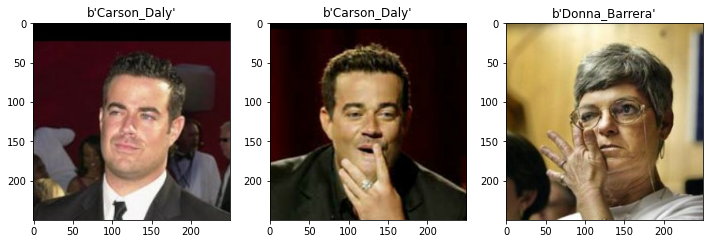

In [188]:
#визуализация выбранных данных из тестового датасета
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
plt.title(person_1)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.title(person_2)
plt.show()

In [189]:
#получение эмбеддингов для новых данных
#(из трех тензоров (250, 250, 3) делаем один (3, 250, 250, 3) и помещаем в модель)
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0)) 

In [190]:
#функция вычисления расстояния между векторами (эмбеддингами)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print(f'{person_1}_1 <-> {person_1}_2: ', diff(emb1, emb2))
print(f'{person_1}_1 <-> {person_2}_1: ', diff(emb1, emb3))
print(f'{person_1}_2 <-> {person_2}_1: ', diff(emb2, emb3))

b'Carson_Daly'_1 <-> b'Carson_Daly'_2:  10.238180649782368
b'Carson_Daly'_1 <-> b'Donna_Barrera'_1:  22.715829527728292
b'Carson_Daly'_2 <-> b'Donna_Barrera'_1:  21.28001169419505


Модель вполне хорошо справляется с задачей.